<a href="https://colab.research.google.com/github/fleshgordo/sensinglikeamultiplicity/blob/main/day2/Analysing_imageDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analysing the Image db

Once we have created a database of images for each locations, we proceed with extracting its most relevant data to describe it in a visually synthetic manner

We first connect to Drive to access our files

In [36]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


and we import the libraries

In [37]:
from tqdm import tqdm
import os
import cv2
import numpy as np
from skimage import io
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot
from matplotlib.pyplot import imshow
from PIL import Image

### Loading the images

make sure to provide the right path to the folder where the images are stored.
Use the UI on the left to find the folder in your drive

In [38]:
data = []
# folder = '/content/drive/MyDrive/.../imgs/' # in Drive
folder = '/content/gdrive/MyDrive/GEE/built/'

for filename in tqdm((os.listdir(folder))):
    image = cv2.imread(os.path.join(folder,filename))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        image = image.flatten()
        data.append([image, folder + filename])

100%|██████████| 100/100 [00:00<00:00, 278.89it/s]


In [39]:
features, images  = zip(*data)

### Feature Extraction
Compute the Principal Component Analysis to extract main patterns in the dataset.
Experiment with different n_components to alter the results

*PCA is a statistical procedure that converts a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.* [Wiki](https://en.wikipedia.org/wiki/Principal_component_analysis)

[INFO](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) - [INFO](https://setosa.io/ev/principal-component-analysis/)

In [40]:
# a number between 0<1 will be understood as % of variance to keep between samples
# a number higher than 1 will be considered as n features to keep
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(features)

features = np.array(features)
pca = PCA(n_components=0.95)
pca.fit(features)
pca_features = pca.transform(features)

### Plot Results - TSNE

**Experiment with different settings**

Keep n_components=2

Perplexity 
In short, a guess about the number of close neighbors, generally in the range of 5 - 50

Learning rate 
In short, how much dense the datapoints will be, generally in the range of 10 - 1000

[INFO](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) - [INFO](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 736.899329
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.973648
[t-SNE] KL divergence after 1000 iterations: 0.283018


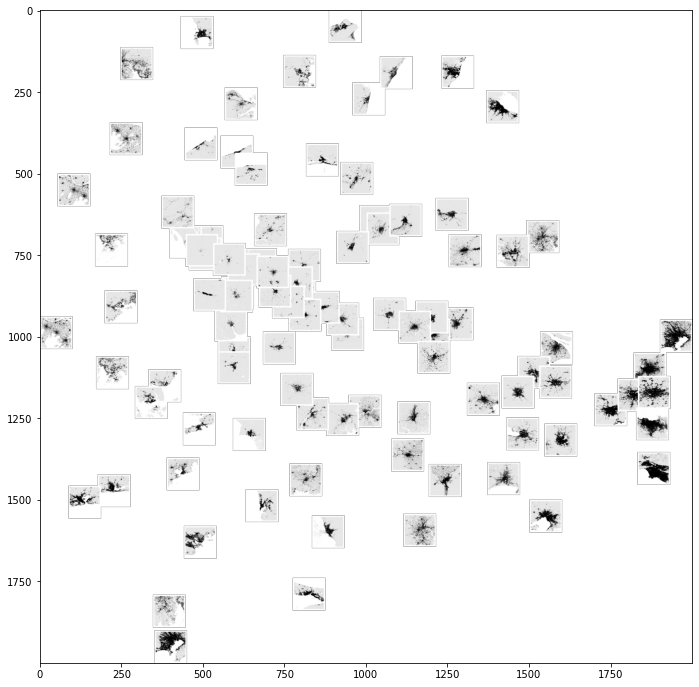

In [41]:
tsne = TSNE(n_components = 2, perplexity = 35, learning_rate = 10, verbose = 1)

width = 2000
height = 2000
max_dim = 100

# Calculate the TSNE
X = np.array(pca_features)
tsne = tsne.fit_transform(X)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)